In [1]:
pip install torchdiffeq

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 43.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
from qutip import *
from torchdiffeq import odeint
import os
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio.v2 as imageio
from IPython.display import clear_output
device = "cuda:0" if torch.cuda.is_available() else "cpu" 

In [5]:
torch.__version__

'1.13.0'

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" 

In [35]:
def normalize(a):
	a_oo = a - np.real(a).min()
	return a_oo/np.abs(a_oo).max()

def get_state(theta, phi):
    ket0, ket1 = np.array([[1.],[0.]]), np.array([[0.],[1.]])
    bloch_state = np.cos(theta/2) * ket0 + np.exp(complex(0, phi))*ket1
    return Qobj(bloch_state)

def get_spherical(theta, phi):
    return np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])

def sample_bloch(n_samples=50, rand=True):
    if rand:
        thetas = np.sort(np.pi * np.random.rand(n_samples))
        phis = np.sort(2 * np.pi * np.random.rand(n_samples))
        
    else:
        thetas = np.linspace(0, np.pi, n_samples)
        phis = np.linspace(0, 2 * np.pi, n_samples)
    
    bloch_vec = np.dstack(np.meshgrid(thetas, phis)) # [n_samples, n_samples, 2]
    return bloch_vec.reshape(n_samples * n_samples, 2) # [n_samples^2, 2]

def sample_initial_states(n_samples=50, rand=True):
    " sample initial states "
    bloch_vecs = sample_bloch(n_samples, rand)
    states = [get_state(*bvec) for bvec in bloch_vecs]
    spherical = np.asarray([get_spherical(*bvec) for bvec in bloch_vecs])

    return states, bloch_vecs, spherical

def final_states_to_numpy(states):
    "convert list of quantum objects to numpy array [2, num_time_steps]"
    return np.concatenate([state.full() for state in states], axis=-1)

class StochasticTwoLevelDataset(Dataset):
    def __init__(self, num_batches=30, batched_samples=6, validation_samples=10, start=0, stop=2, last=10, time_steps=150, mc_samples=250, dataset_type='closed'): 
        self.total_time_steps = np.linspace(start, last, time_steps)
        self.initial_states, _, self.spherical = sample_initial_states(batched_samples, rand=True)
        self.validation_points = sample_initial_states(validation_samples, rand=False)
        self.num_per_batch = batched_samples ** 2
        self.num_batches = num_batches
        self.num_trajs = self.num_per_batch * self.num_batches
        self.dataset_type = dataset_type

        if dataset_type == 'closed':
            self.rand_parameters = np.zeros((num_batches, 2))
        elif dataset_type == 'open':
            self.rand_parameters = np.zeros((num_batches, 4))
        expect_data = []
        for i in range(num_batches):
            samp_z = np.random.uniform(1, 2.5, 1)
            samp_x = np.random.uniform(1, 2.5, 1)
            self.rand_parameters[i, 0] = samp_z
            self.rand_parameters[i, 1] = samp_x
            H = samp_z[0] * sigmaz() + samp_x[0] * sigmax()

            if dataset_type == 'closed':
                solve = lambda state : sesolve(H, state, self.total_time_steps, e_ops=[sigmax(), sigmay(), sigmaz()], progress_bar=None)
            elif dataset_type == 'open':
                decay_samp = np.random.uniform(0.1, 0.3, 2)
                self.rand_parameters[i, 2:] = decay_samp
                c_ops = [np.sqrt(decay_samp[0]) * sigmax(), np.sqrt(decay_samp[1]) * sigmaz()]
                solve = lambda state : mesolve(H, state, self.total_time_steps, e_ops=[sigmax(), sigmay(), sigmaz()], c_ops=c_ops)
                
            all_states = [solve(state).expect for state in self.initial_states]
            states = [np.asarray(states, dtype='double') for states in all_states] 
            states = np.asarray([np.column_stack([state[0], state[1], state[2]]) for state in states])
            expect_data.append(states)
            
        self.expect_data = np.asarray(expect_data)
        self.total_expect_data = self.expect_data.reshape(self.num_trajs, time_steps, 3)
        self.train_time_steps = self.total_time_steps[np.where(self.total_time_steps <= stop)]
        self.train_expect_data = self.total_expect_data[:,:self.train_time_steps.shape[0],:]

    def plot_trajs(self):
        for i in range(self.num_batches):
            for j in range(self.num_per_batch):
                ts = self.time_steps
                fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

                ax1.plot(ts, self.expect_data[i, j, :, 0])
                ax1.set_ylim(-1, 1)
                ax1.set_ylabel('$\sigma_x$')

                ax2.plot(ts, self.expect_data[i, j, :, 1])
                ax2.set_ylim(-1, 1)
                ax2.set_ylabel('$\sigma_y$')

                ax3.plot(ts, self.expect_data[i, j, :, 2])
                ax3.set_ylim(-1, 1)
                ax3.set_ylabel('$\sigma_z$')
                if self.dataset_type == 'closed':
                    ax3.set_xlabel('H = {}z + {}x'.format(self.rand_parameters[i, 0], self.rand_parameters[i, 1]))
                else:
                    ax3.set_xlabel('H = {}z + {}x decay: {} {}'.format(*self.rand_parameters[i]))

                plt.savefig('plots/stochastic_closed_noise/traj_{}_{}.png'.format(i, j))
                plt.close(fig)

    def render_initial_states(self, directory):
        bloch = Bloch()
        colors = normalize(self.spherical)
        bloch.point_color = colors
        bloch.add_points([self.spherical[:, 0], self.spherical[:, 1], self.spherical[:, 2]], 'm')
        bloch.save(directory)

# two qubit functions

In [36]:
class LatentODEfunc(nn.Module):
    
    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.nfe = 0
        self.ode = nn.Sequential(
            nn.Linear(latent_dim, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, latent_dim),

        )

    def forward(self, t, x):
        self.nfe += 1
        result = self.ode(x)
        return result.to(device)



class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=3, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1).to(device)
        #  combined = torch.cat((x, h), dim=1).to('cpu')
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out.to(device), h.to(device)

    def initHidden(self, batch=0):
        if batch == 0:
            return torch.zeros(self.nbatch, self.nhidden).to(device)
        else:
            return torch.zeros(batch, self.nhidden).to(device)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20, extra=False):
        super(Decoder, self).__init__()
        self.extra = extra
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.tanh(out)
        if self.extra:
            out = self.fc2(out)
            out = self.tanh(out)
            out = self.fc3(out)
        else:
            out = self.fc3(out)
        return out.to(device)


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(device)
    const = torch.log(const)
    return -.5 * (const + logvar.to(device) + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1).to(device)
    v2 = torch.exp(lv2).to(device)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl




class latent_ode(torch.nn.Module):
    def __init__(self,obs_dim=2, latent_dim=4, nhidden=20, rnn_nhidden=25, data = None, lr=1e-2, batch=1000, beta=1, extra_decode=False):
        super().__init__()
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim
        self.nhidden = nhidden
        self.rnn_nhidden = rnn_nhidden
        self.beta = beta
        self.data = data
        self.epsilon = None
        self.func = LatentODEfunc(latent_dim, nhidden)
        self.rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, batch)
        self.dec = Decoder(latent_dim, obs_dim, nhidden, extra=extra_decode)
        self.params = (list(self.func.parameters()) + list(self.dec.parameters()) + list(self.rec.parameters()))
        self.lr = lr
        self.optimizer = optim.Adam(self.params, lr=self.lr)


    def train(self, trajs, ts, num_epochs):
        # dataset parameters
        num_ts = ts.size(0)
        beta = self.beta
        bloch = qutip.Bloch()
        os.makedirs('./plots/train',exist_ok = True)
        for itr in range(num_epochs):
            self.rec.to(device)
            self.func.to(device)
            self.optimizer.zero_grad()
            h = self.rec.initHidden()
            self.rec.to(device)
            for t in reversed(range(num_ts)):
                obs = trajs[:, t, :]
                out, h = self.rec.forward(obs, h)
            qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
            qz0_mean = qz0_mean.to(device)
            qz0_logvar = qz0_logvar.to(device)
            epsilon = torch.randn(qz0_mean.size()).to(device)
            z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
            z0 = z0.to(device)

            # forward in time and solve ode for reconstructions
            pred_z = odeint(self.func, z0, ts).permute(1, 0, 2)
            pred_x = self.dec(pred_z)
            pred_x = pred_x.to(device)

            # compute loss
            noise_std_ = torch.zeros(pred_x.size()) + 0.3
            noise_logvar = 2. * torch.log(noise_std_)
            noise_logvar = noise_logvar.to(device)
            logpx = log_normal_pdf(
                trajs, pred_x, noise_logvar).sum(-1).sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = beta * normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            lagrange = (1 - pred_x[:,:,0]**2 - pred_x[:,:,1]**2 - pred_x[:,:,2]**2).sum(-1)
            loss = torch.mean(-logpx + analytic_kl+ 0.2*torch.abs(lagrange), dim=0).to(device)
            loss.backward()
            av_mse, *_ = self.MSE(trajs, ts)
            self.optimizer.step()
            metrics['Elbo'].append(loss.to('cpu').detach().numpy())
            metrics['train_loss'].append(av_mse)
            if itr == num_epochs:
                self.epsilon = epsilon
            print('Epoch: {}, elbo: {:.4f}, mse: {:.4f}'.format(itr, loss, av_mse))
            
            if  itr % 300 == 0:
                clear_output(True)
                coor0 = pred_x.cpu().detach().numpy()
                x0 = coor0[0,:,0]
                y0 =  coor0[0,:,1]
                z0 =  coor0[0,:,2]
                coor1 = trajs.cpu().detach().numpy()
                x1 = coor1[0,:,0]
                y1 =  coor1[0,:,1]
                z1 =  coor1[0,:,2]
                bloch.render()
                bloch.add_points([x1,y1,z1])
                bloch.add_points([x0,y0,z0])
                bloch.show()
                
                plt.figure(figsize=[12, 4])
                plt.subplot(1,2,1)
                plt.plot(metrics['train_loss'], label='MSE')
                plt.legend()
                plt.grid()
                plt.subplot(1,2,2)
                plt.plot(metrics['Elbo'], label='Elbo')
                plt.legend()
                plt.grid()
                plt.show()
                plt.savefig('./plots/train/train_cicle{}'.format(itr))
                bloch.clear()

                








    def encode(self, trajs, ts, reconstruct=True):
        if (reconstruct):
            with torch.no_grad():
                num_ts = ts.size(0)
                # sample from trajectorys' approx. posterior
                h = self.rec.initHidden(batch=trajs.shape[0]).to(device)
                for t in reversed(range(num_ts)):
                    obs = trajs[:, t, :]
                    out, h = self.rec.forward(obs, h)
                qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
                z0 = qz0_mean #self.epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        else:
            with torch.no_grad():
                num_ts = ts.size(0)
                # sample from trajectorys' approx. posterior
                h = self.rec.initHidden(batch=trajs.shape[0])
                for t in reversed(range(num_ts)):
                    obs = trajs[:, t, :]
                    out, h = self.rec.forward(obs, h)
                qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
                epsilon = torch.randn(qz0_mean.size()).to(device)
                z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        return z0.to(device)

    def decode(self, z0, ts):
        with torch.no_grad():
            if len(z0.shape) == 1:
                pred_z = odeint(self.func, z0, ts)
            else:
                pred_z = odeint(self.func, z0, ts).permute(1, 0, 2)
            pred_x = self.dec(pred_z)
        return pred_x.to(device)

    def latent_dynamics(self, trajs, enc_ts, dec_ts, recontruct=True):
        z0 = self.encode(trajs, enc_ts, recontruct)
        print('z0',z0.shape)
        with torch.no_grad():
            if len(z0.shape) == 1:
                pred_z = odeint(self.func, z0, dec_ts)
            else:
                pred_z = odeint(self.func, z0, dec_ts).permute(1, 0, 2)
        return pred_z.to(device)


    def MSE(self, trajs, train_ts):
        z0 = self.encode(trajs, train_ts)
        pred_x = self.decode(z0, train_ts)

        mse_errors = np.mean((trajs.cpu().numpy() - pred_x.cpu().numpy()) ** 2, axis=1)
        mse_errors = np.mean(mse_errors, axis=1)
        avg_mse = np.mean(mse_errors)

        return avg_mse, mse_errors

In [37]:
def save_dataset(data, dataset_name):
    torch.save(data, '/kaggle/working/{}.pt'.format(dataset_name))

def load_dataset():
    return torch.load('/kaggle/working/closed-0.pt')

In [40]:
seed = 0
types = 'closed'
epochs = 2000
obs_dim = 3
latent_dim = 6
rnn_nhidden = 48
nhidden = 48
lr = 1e-3
metrics = {'train_loss': [], 'Elbo': [] }

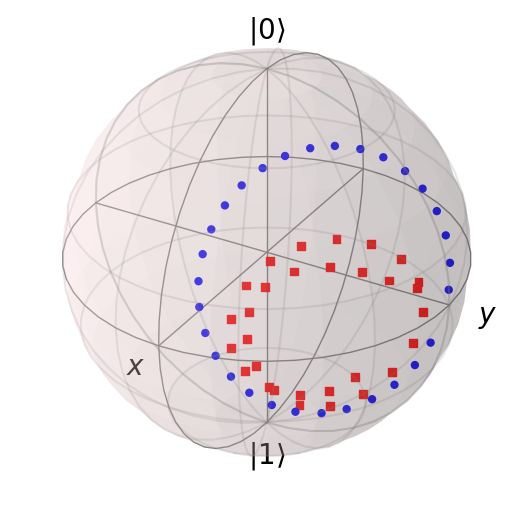

<Figure size 640x480 with 0 Axes>

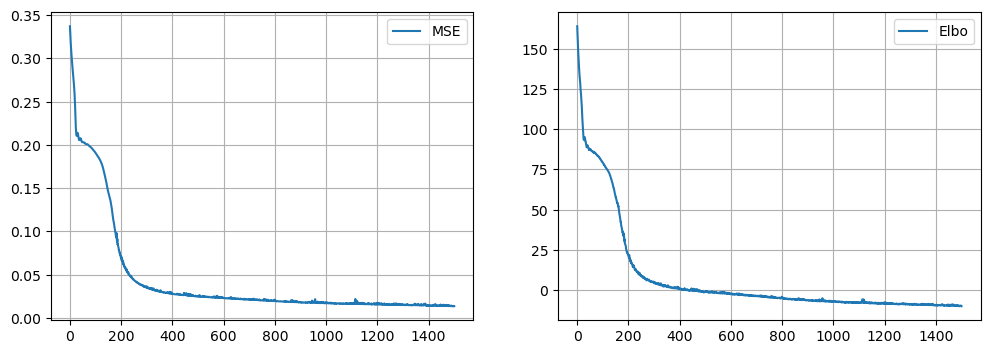

Epoch: 1501, elbo: -10.1187, mse: 0.0133
Epoch: 1502, elbo: -10.0412, mse: 0.0134
Epoch: 1503, elbo: -10.0256, mse: 0.0135
Epoch: 1504, elbo: -9.8535, mse: 0.0134
Epoch: 1505, elbo: -10.0067, mse: 0.0136
Epoch: 1506, elbo: -9.9034, mse: 0.0133
Epoch: 1507, elbo: -9.9757, mse: 0.0134
Epoch: 1508, elbo: -10.0871, mse: 0.0135
Epoch: 1509, elbo: -10.0984, mse: 0.0133
Epoch: 1510, elbo: -9.9990, mse: 0.0137
Epoch: 1511, elbo: -10.0612, mse: 0.0134
Epoch: 1512, elbo: -10.0794, mse: 0.0134
Epoch: 1513, elbo: -10.0960, mse: 0.0138
Epoch: 1514, elbo: -9.8218, mse: 0.0134
Epoch: 1515, elbo: -9.9266, mse: 0.0137
Epoch: 1516, elbo: -10.0942, mse: 0.0133
Epoch: 1517, elbo: -10.1708, mse: 0.0133
Epoch: 1518, elbo: -10.0874, mse: 0.0137
Epoch: 1519, elbo: -10.0240, mse: 0.0133
Epoch: 1520, elbo: -9.8471, mse: 0.0135
Epoch: 1521, elbo: -10.0995, mse: 0.0132
Epoch: 1522, elbo: -10.1241, mse: 0.0133
Epoch: 1523, elbo: -9.9706, mse: 0.0135
Epoch: 1524, elbo: -10.0070, mse: 0.0134
Epoch: 1525, elbo: -9.70

In [ ]:
if __name__ == "__main__":
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # initializing the dataset
    data = StochasticTwoLevelDataset(dataset_type= types)
    save_dataset(data, '{}-{}'.format(types, seed))
    print('dataset {}-{} saved'.format(types, seed))

    #initializing the model
    trajs = torch.from_numpy(data.train_expect_data).float().to(device)
    ts = torch.from_numpy(data.train_time_steps).float().to(device)
    model = latent_ode(obs_dim=obs_dim, latent_dim= latent_dim, nhidden=nhidden, 
        rnn_nhidden=rnn_nhidden, data = data, lr=lr, batch=data.train_expect_data.shape[0])
    model.to(device)
    model.train(trajs, ts, epochs)
    

In [67]:
torch.save(model.state_dict(),'test_1' )

In [68]:
model1 = latent_ode(obs_dim=obs_dim, latent_dim= latent_dim, nhidden=nhidden, 
        rnn_nhidden=rnn_nhidden, data = data, lr=lr, batch=data.train_expect_data.shape[0])
model1.to(device) 
model1.load_state_dict(torch.load('/kaggle/working/test'))

<All keys matched successfully>

In [69]:
bloch = qutip.Bloch()


In [76]:
data = load_dataset()

In [83]:
n = data.total_expect_data.shape[0]
ts = torch.from_numpy(data.total_time_steps).float().to(device)
idxe = np.where(np.logical_and(data.total_time_steps >= 2, data.total_time_steps <= 6))[0]
idxt = np.where(data.total_time_steps <= 2)[0]
rands = np.random.randint(0, n, 20)
np_trajs = data.total_expect_data[0:10]
trajs = torch.from_numpy(np_trajs).float().to(device)


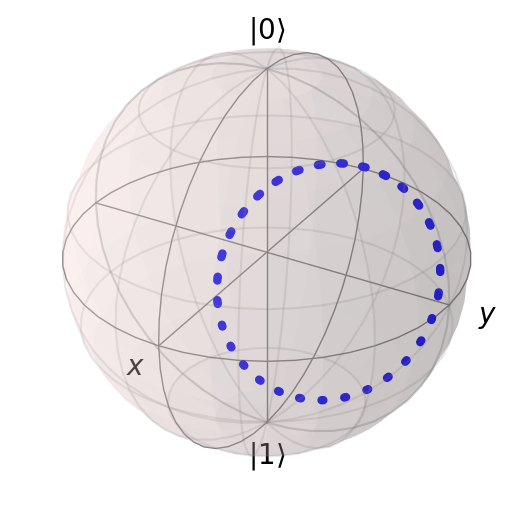

In [108]:
bloch = qutip.Bloch()
a1 = np_trajs[1,:80,0]
b1 = np_trajs[1,:80,1]
c1 = np_trajs[1,:80,2]
bloch.add_points([a1,b1,c1]) 
#bloch.add_points([a,b,c]) 
bloch.show()

In [106]:

xm = model.decode(model.encode(trajs,ts), ts).to('cpu').numpy()
xm.shape

(10, 300, 3)

In [98]:
torch.randn(1, 6).shape

torch.Size([1, 6])

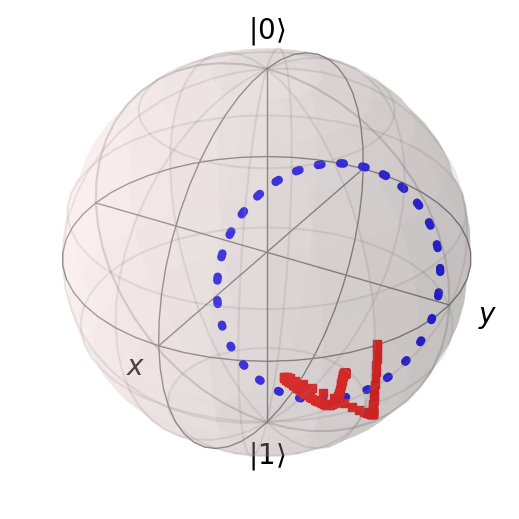

In [109]:
bloch.render()
a = xm[1,120:300,0]
b = xm[1,120:300,1]
c = xm[1,120:300,2]
bloch.add_points([a,b,c]) 
bloch.show()

 

In [100]:
mod = xm[0,:,0]**2 +xm[0,:,1]**2+xm[0,:,2]**2

In [82]:
mod

array([0.6331332 , 0.6387943 , 0.64184463, 0.64276135, 0.6422104 ,
       0.6411269 , 0.64072907, 0.6425531 , 0.6484651 , 0.66051316,
       0.6806574 , 0.7103554 , 0.7498606 , 0.7978864 , 0.85141504,
       0.9060688 , 0.95695376, 0.9990402 , 1.0277643 , 1.0408708 ,
       1.0408628 , 1.0348042 , 1.030073  , 1.0293678 , 1.0298299 ,
       1.0269243 , 1.019013  , 1.0084999 , 0.9992507 , 0.99303406,
       0.98837215, 0.98261786, 0.9748791 , 0.9670063 , 0.96216136,
       0.9626134 , 0.9678494 , 0.97414136, 0.9766303 , 0.9730015 ,
       0.96560216, 0.9596125 , 0.95903635, 0.9643473 , 0.9731873 ,
       0.98260427, 0.9906448 , 0.99692893, 1.0021805 , 1.0072986 ,
       1.0122279 , 1.0153558 , 1.0147381 , 1.0102307 , 1.0036774 ,
       0.9974493 , 0.9935067 , 0.9928418 , 0.9948714 , 0.9972805 ,
       0.99727535, 0.9936843 , 0.9877856 , 0.9819951 , 0.97776914,
       0.9748037 , 0.9718388 , 0.9679579 , 0.96326894, 0.9586337 ,
       0.954944  , 0.9529778 , 0.954077  , 0.9602963 , 0.97378

In [253]:
mod_norm = trajs[0,:,0]**2 +trajs[0,:,1]**2+trajs[0,:,2]**2

In [254]:
mod_norm

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 